# Initialization

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

'''
Common google drive for project files and dataset. Mount with this drive.
email: ecse415project2022@gmail.com
password: mcgillecse415
'''
path = "/content/drive/MyDrive/ecse415-project/dataset_given"

Mounted at /content/drive


In [2]:
import time
import numpy as np
import cv2
import os
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation
import random
import pickle

In [3]:
#The version of cv2 needed is 4.4. As mentioned in Tutorial 4, the following command must be run to install the appropriate cv2 library.
!pip install opencv-python==4.4.0.44
!pip install opencv-contrib-python==4.4.0.44

     |████████████████████████████████| 49.5 MB 102 kB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


     |████████████████████████████████| 55.7 MB 1.3 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


# Testing on labeled dataset

## Helper methods (run all)

In [4]:
def parse(filepath):
  '''
      Parse gt.txt with format
        <frame>, <id>, <type>, <truncated>, <occluded>, <alpha>, <bb_left>, <bb_top>, <bb_right>, <bb_bottom>, <3D_H>, <3D_W>, <3D_L>, <x>, <y>, <z>, <ry>
      Return dict as:
        <type> = "Car", "Van", "Truck", "Pedastrian", "Person_sitting", "Cyclist", "Tram", "Misc", "DontCare"
        key: frame
        value: list - <id>, <bb_left>, <bb_top>, <bb_right>, <bb_bottom>
      Feel free to edit your structure as needed!
  '''

  used_type = ["Car", "Van", "Truck", "Tram"]

  lines = open(filepath, "r").readlines()                                 
  bbox = {}
       #  <frame>, <id>, <truncated>, <occluded>, <alpha>, <bb_left>, <bb_top>, <bb_right>, <bb_bottom>, <3D_H>, <3D_W>, <3D_L>, <x>,   <y>,   <z>,   <ry>
  mask = [False,   True,  False,       False,      False,   True,      True,     True,       True,        False,  False,  False,  False, False, False, False]
  
  for line in lines:
    l = line.strip().split(' ') #convert line to list
    typ = l.pop(2)  # get type of bbox 
    line = np.asarray(l).astype(np.float32) # convert into array 
    frame, line = int(line[0]), line[mask] # get frame number and mask the line   
    if frame not in bbox.keys():
      bbox[frame] = []   
    if typ in used_type:
        bbox[frame].append(line)
  return bbox

def add_bbox(img, bbox, color=(255, 0, 0), thickness=2):
  ''' 
    annotate an image with bounding boxes:
    supports single bbox or list of bboxs
  '''

  annotated = np.copy(img)
  if bbox: 
    if isinstance(bbox[0], np.ndarray) or isinstance(bbox[0], list):
        for (_,x1,y1,x2,y2) in bbox:
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            cv2.rectangle(annotated, (x1, y1), (x2, y2), color , thickness)
    else:
        _,x1,y1,x2,y2 = bbox
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        cv2.rectangle(annotated, (x1, y1), (x2, y2), color , thickness)
  
  return annotated


In [5]:
# A function to help draw optical flow with flow lines
def draw_flow(img1, img2, flow, step=16):
  h, w = img1.shape[:2]
  y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
  fx, fy = flow[y,x].T
  lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
  lines = np.int32(lines + 0.5)
  vis = img1.copy()#cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
  cv2.polylines(vis, lines, 0, (0, 255, 0))
  for (x1, y1), (x2, y2) in lines:
      cv2.circle(vis, (x1, y1), 1, (0, 255, 0), -1)
  return vis

In [6]:
def get_flow_farneback(img1, img2):
  img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
  img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
  flow = cv2.calcOpticalFlowFarneback(prev=img1_gray, 
                                  next=img2_gray, 
                                  flow=None,
                                  pyr_scale=0.5, 
                                  levels=3, 
                                  winsize=15,
                                  iterations=5, 
                                  poly_n=5, 
                                  poly_sigma=1.2, 
                                  flags=0)
  return flow

In [7]:
def get_next_bboxes(img1, img2, bboxes, flow_func):
  '''
  Given two images and the bounding boxes of the first,
  calculate flow and return a list of bboxes for the second image
  '''
  h, w = img1.shape[0], img1.shape[1]
  flow = flow_func(img1, img2)
  next_bboxes = []
  for bbox in bboxes:
    # for each bbox, compute flow inside and get mean flow
    # should bbox shrink?
    (_,x1,y1,x2,y2) = bbox
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    bbox_flow = flow[y1:y2, x1:x2]
    # plt.imshow(draw_flow(img1, img2, flow, step=4)[y1:y2, x1:x2])
    bbox_flow = np.reshape(bbox_flow, (bbox_flow.shape[0]*bbox_flow.shape[1], 2))
    avg_bbox_flow = np.mean(bbox_flow, axis=0) # The tutorial 11 said we should use the mean here
    dx, dy = avg_bbox_flow[0], avg_bbox_flow[1]
    x1, y1, x2, y2 = min(max(0, x1 + dx), w - 1), min(max(0, y1 + dy), h - 1), min(max(0, x2 + dx), w - 1), min(max(0, y2 + dy), h - 1)
    next_bboxes.append([None, x1, y1, x2, y2])
  return next_bboxes
  
def track_video_sequence(images, first_img_bboxes, flow_func):
  '''
  Given set of images and bboxes for first image, track the bounding boxes.
  Return list of bboxes (one list of bboxes for every frame)
  '''
  bboxes = [first_img_bboxes]
  for i, curr_img in enumerate(images[1:]):
    i = i + 1
    prev_img = images[i - 1]
    prev_bboxes = bboxes[i -1]
    # print()
    # print("NEW IMAGE")
    curr_bboxes = get_next_bboxes(prev_img, curr_img, prev_bboxes, flow_func)
    bboxes.append(curr_bboxes)  

  return bboxes


def track_video_sequence(images, first_img_bboxes, flow_func):
  '''
  Given set of images and bboxes for first image, track the bounding boxes.
  Return list of bboxes (one list of bboxes for every frame)
  '''
  bboxes = [first_img_bboxes]
  for i, curr_img in enumerate(images[1:]):
    i = i + 1
    prev_img = images[i - 1]
    prev_bboxes = bboxes[i -1]
    # print()
    # print("NEW IMAGE")
    curr_bboxes = get_next_bboxes(prev_img, curr_img, prev_bboxes, flow_func)
    bboxes.append(curr_bboxes)  

  return bboxes

def track_video_sequence_in_steps(images, bboxes, stepSize, flow_func):
  '''
  This function relocalizes (with ground truth) at each step size.
  '''
  all_bboxes = []

  for i in range(0, len(images), stepSize):
    step_bboxes = track_video_sequence(images[i:i + stepSize], bboxes[i], flow_func)
    all_bboxes = all_bboxes + step_bboxes
  return all_bboxes

def track_video_sequence_in_steps_localizer(images, localizer_func, model, stepSize, flow_func):
  '''
  This function relocalizes (with ground truth) at each step size.
  '''
  all_bboxes = []

  for i in range(0, len(images), stepSize):
    bboxes = localizer_func(images[i], model, True)
    bboxes = [[None, patch.x, patch.y, patch.x + patch.w, patch.y + patch.h] for patch in bboxes]
    step_bboxes = track_video_sequence(images[i:i + stepSize], bboxes, flow_func)
    all_bboxes = all_bboxes + step_bboxes
  return all_bboxes

def track_video_sequence_localizer(images, localizer_func, model, flow_func):
  '''
  Given set of images and bboxes for first image, track the bounding boxes.
  Return list of bboxes (one list of bboxes for every frame)
  '''
  bboxes = localizer_func(images[0], model, True)
  bboxes = [[None, patch.x, patch.y, patch.x + patch.w, patch.y + patch.h] for patch in bboxes]

  return track_video_sequence(images, bboxes, flow_func)

## Testing it

In [ ]:
bboxes_0002 = parse(os.path.join(path, "0002.txt"))

In [10]:
def perform_tracking_and_save(input_dirpath, init_bboxes, output_dirpath):
  '''
  Function to use optical flow (farneback) to track objects in a video sequence
  '''
  images = []

  for f in sorted(os.listdir(input_dirpath)):
    img = cv2.imread(os.path.join(input_dirpath, f))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)

  bboxes = track_video_sequence(images, init_bboxes, get_flow_farneback)

  print(bboxes)

  for i, bbox in enumerate(bboxes):
    annotated_img = add_bbox(images[i], bbox)
    io.imsave(os.path.join(output_dirpath, f'{i}.png'), annotated_img)

def perform_tracking_in_steps_and_save_localizer(input_dirpath, localizer_func, model, step_size, output_dirpath):
  '''
  Function to use optical flow (farneback) to track objects in a video sequence
  '''
  images = []

  for f in sorted(os.listdir(input_dirpath)):
    img = cv2.imread(os.path.join(input_dirpath, f))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)

  bboxes = track_video_sequence_in_steps_localizer(images, localizer_func, model, step_size, get_flow_farneback)

  print(bboxes)

  for i, bbox in enumerate(bboxes):
    annotated_img = add_bbox(images[i], bbox)
    io.imsave(os.path.join(output_dirpath, f'{i}.png'), annotated_img)
  
  return bboxes

In [ ]:
bboxes_0002 = parse(os.path.join(path, "0002.txt"))

input_dirpath = os.path.join(path, 'tracking')
output_dirpath = os.path.join(path, 'tracked_optical_flow')
init_bboxes = bboxes_0002[169] # using last labeled image
print(init_bboxes)
init_bboxes = [[None, 537.215959, 134.737612, 823.458881, 210.862326], [None, 0.000000, 168.995742, 100.4367, 312.47685]]
perform_of_tracking_and_save(input_dirpath, init_bboxes, output_dirpath)

[array([  7.     ,   0.     , 168.99574, 162.40015, 312.47684],
      dtype=float32), array([  8.     , 552.21594, 134.73761, 838.45886, 210.86232],
      dtype=float32), array([ 16.     , 558.9543 , 178.02261, 587.4449 , 197.46439],
      dtype=float32), array([ 17.     , 511.85742, 178.85251, 545.38434, 198.59079],
      dtype=float32), array([ 18.     , 577.97394, 176.72318, 601.0054 , 194.63542],
      dtype=float32), array([ 19.     , 534.3547 , 179.59517, 562.34796, 196.30424],
      dtype=float32)]


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


[[[None, 537.215959, 134.737612, 823.458881, 210.862326], [None, 0.0, 168.995742, 100.4367, 312.47685]], [[None, 527.0479717254639, 134.2491480410099, 813.0479717254639, 210.2491480410099], [None, 0.8175492882728577, 170.1746425628662, 100.81754928827286, 314.1746425628662]], [[None, 516.872486114502, 133.95742791891098, 802.872486114502, 209.95742791891098], [None, 0, 172.20716428756714, 94.28885269165039, 316.20716428756714]], [[None, 506.0196723937988, 133.2582212984562, 792.0196723937988, 209.2582212984562], [None, 0, 173.4777271747589, 91.21828389167786, 317.4777271747589]], [[None, 498.3419256210327, 133.0964570119977, 784.3419256210327, 209.0964570119977], [None, 0, 173.24722282588482, 90.80487775802612, 317.2472228258848]], [[None, 489.16998767852783, 132.95003597810864, 775.1699876785278, 208.95003597810864], [None, 0, 172.84522917866707, 89.84105718135834, 316.84522917866707]], [[None, 480.3730306625366, 132.16215811669827, 766.3730306625366, 208.16215811669827], [None, 0, 17

##Tracking video sequence

# Tutorial: Motion Exercise

(100, 1, 2)


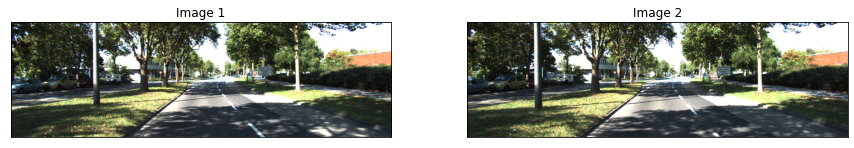

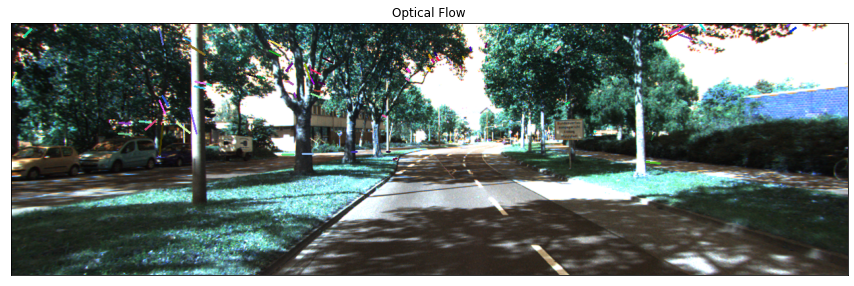

In [ ]:
# read images
img1 = cv2.imread(path+"/0002/000000.png")
img2 = cv2.imread(path+"/0002/000001.png")
# convert to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# convert to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )


p0 = cv2.goodFeaturesToTrack(img1_gray, **feature_params)

lk_params = dict( winSize = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT,
                             10, 0.03))

p1, st, _ = cv2.calcOpticalFlowPyrLK(img1_gray, img2_gray, p0, None, **lk_params)

# select good points
good_new = p1[st==1]
good_old = p0[st==1]
print(p1.shape)


# create some random colors
color = np.random.randint(0, 255, (good_new.shape[0], 3))

# create a mask image for drawing purposes
mask = img1.copy()

# draw the tracks
for i, (new, old) in enumerate(zip(good_new, good_old)):
    a, b = new.ravel()
    c, d = old.ravel()
    mask = cv2.line(mask, (a,b), (c,d), color[i].tolist(), 2)

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title("Image 1"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title("Image 2"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(15,15))
plt.imshow(mask)
plt.title("Optical Flow"), plt.xticks([]), plt.yticks([])
plt.show()

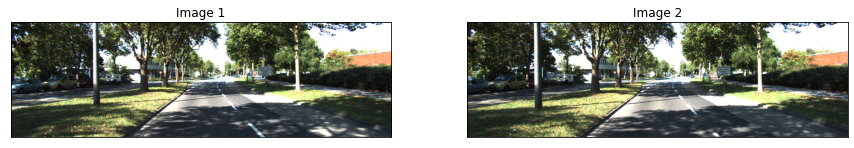

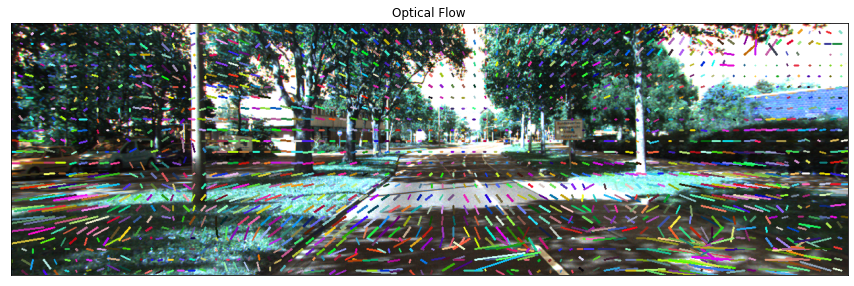

In [ ]:
# LP Optical flow

# convert to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# parameters for lucas kanade optical flow
lk_params = dict( winSize = (50,50),
                  maxLevel = 1,
                  minEigThreshold = 0,#0.001,
                  criteria = (cv2.TERM_CRITERIA_COUNT | cv2.TERM_CRITERIA_EPS,10, 0.1),
                  )

# create grid for dense optic flow
# Note that here we are not calculating optical flow for only "interesting points" (good feature to track)
# instead of that we are taking every 16th pixel in both directions and calculating optical flow for all of them
x = np.arange(0, img1_gray.shape[1],16)
y = np.arange(0, img1_gray.shape[0],16)
xv, yv = np.meshgrid(x, y)
p0 = np.concatenate([xv.reshape(-1,1,1), yv.reshape(-1,1,1)],2).astype(np.float32)

# compute optic flow
p1, st, _ = cv2.calcOpticalFlowPyrLK(img1_gray, img2_gray, p0, None, **lk_params)

# select good points
good_new = p1[st==1]
good_old = p0[st==1]


# create some random colors
color = np.random.randint(0, 255, (good_new.shape[0], 3))

# create a mask image for drawing purposes
mask = img1.copy()

# draw the tracks
for i, (new, old) in enumerate(zip(good_new, good_old)):
    a, b = new.ravel()
    c, d = old.ravel()
    mask = cv2.line(mask, (a,b), (c,d), color[i].tolist(), 2)

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title("Image 1"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title("Image 2"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(15,15))
plt.imshow(mask)
plt.title("Optical Flow"), plt.xticks([]), plt.yticks([])
plt.show()


In [ ]:
# A function to help draw optical flow with flow lines
def draw_flow(img, flow, step=16):
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T
    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    vis = img.copy()#cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(vis, lines, 0, (0, 255, 0))
    for (x1, y1), (x2, y2) in lines:
        cv2.circle(vis, (x1, y1), 1, (0, 255, 0), -1)
    return vis


# Tracking Technique Tutorial 12


# IOU 

In [34]:
IMG_SHAPE = (375, 1242) # each image is the same resolution

def getIOUFast(true_boxes, predicted_boxes):
  """
  This function will calculate the IOU for 1 image given
  the true bounding boxes and the predicted ones.

  The idea here is to create 2 numpy arrays of all zeroes. We will fill one 
  with 1s if a true bounding box is present, and another with 1s if a predicted
  bounding box is present in that location.

  We can use logical and / logical or of those two numpy arrays to get the
  IOU.
  """

  pred = np.zeros(IMG_SHAPE)
  true = np.zeros(IMG_SHAPE)

  for (_, x1, y1, x2, y2) in true_boxes:
    # true_box = [bounding_box_id, <bb_left>, <bb_top>, <bb_right>, <bb_bottom>]
    for i in range(int(x1), int(x2) + 1):
      for j in range(int(y1), int(y2) + 1):
        true[j][i] = 1

  #plt.imshow(true, cmap="gray")
  
  for (_, x1, y1, x2, y2) in predicted_boxes:
    for i in range(int(x1), int(x2) + 1):
      for j in range(int(y1), int(y2) + 1):
        pred[j][i] = 1
  
  #plt.imshow(pred, cmap="gray")
  log_and = np.logical_and(true, pred)
  log_or = np.logical_or(true, pred)

  if len(log_or[log_or == True]) != 0:
    iou_coeff = (len(log_and[log_and == True]) / len(log_or[log_or == True]))
  else:
    iou_coeff = 1.0

  #return len(log_and[log_and == True]) / len(log_or[log_or == True])
  return true, pred, iou_coeff

def getAllIOU(all_true_boxes, all_predicted_boxes):
  """
  This function will calculate the IOU for each image given a 2 lists.
  The first contains ground truth labels for bounding boxes.
  The second contains predicted labels for bounding boxes.
  Note that they must be the same size, and in the same order.
  """
  
  iouCoeff = []

  for i in range(0, len(all_predicted_boxes)):
    _, _, coeff = getIOUFast(all_true_boxes[i], all_predicted_boxes[i])
    iouCoeff.append(coeff)

  return iouCoeff

## Mean IOU for Validation Sets

In [25]:
def get_images(dirpath):
  images = []
  for f in sorted(os.listdir(dirpath)):   # perform tracking for first 15 images
    img = cv2.imread(os.path.join(dirpath, f))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)
  return images

images_0000 = get_images(os.path.join(path, "0000"))
images_0001 = get_images(os.path.join(path, "0001"))
images_0002 = get_images(os.path.join(path, "0002"))

true_bboxes_0000 = parse(os.path.join(path, "0000.txt"))
true_bboxes_0001 = parse(os.path.join(path, "0001.txt"))
true_bboxes_0002 = parse(os.path.join(path, "0002.txt"))

## Localizer Methods

In [12]:
RESIZE_WIDTH = 110
RESIZE_HEIGHT = 72

# RESIZE_HEIGHT = 64
# RESIZE_WIDTH = 128

cell_size = (8, 8)  # h x w in pixels
block_size = (2, 2)  # h x w in cells
nbins = 9  # number of orientation bins

# winSize is the size of the image cropped to an multiple of the cell size
# cell_size is the size of the cells of the img patch over which to calculate the histograms
# block_size is the number of cells which fit in the patch
hog = cv2.HOGDescriptor(_winSize=(RESIZE_WIDTH // cell_size[1] * cell_size[1],
                                  RESIZE_HEIGHT // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)


def getLabelHOG(image, model):
  # plt.imshow(image)
  img = image.copy()
  img = cv2.resize(image, (RESIZE_WIDTH, RESIZE_HEIGHT), interpolation=cv2.INTER_AREA)
  feat = hog.compute(img)
  feat = feat.astype(float).reshape(1, -1)
  prediction = model.predict(feat)
  # if prediction[0] == 1:
  #   plt.figure(figsize=(25,25))
  #   plt.subplot(131), plt.imshow(image)
  #   plt.title("detected")
  #   plt.show()
  return prediction

In [13]:
class Patch():
    def __init__(self,x: float,
                 y: float,
                 w: float,
                 h: float):
        self.x = x
        self.y = y
        self.w = w
        self.h = h
    def __str__(self):
        return "x: {0}\ty: {1}\tw: {2}\th: {3}".format(self.x,self.y,self.w, self.h)


def sliding_window(img: np.ndarray, patch_size: float = 30, non_intersected_percentage: float = 0.5, custom_patch_sizes = []):
    """find all patches of a certain size
    
    Parameters
    ----------
    img : np.ndarray
        The image. 
    patch_size : float, optional
        The size of the patch
    non_intersected_percentage: float, optional
        a percentage of non intersected area between the patches
    custom_patch_sizes: [[width,height], [width,height]...] optional

    Returns
    -------
    list[Patch]
        a list of all the patches
    np.ndarray
        img with patches
    """
    copy = img.copy()
    max_width = img.shape[1]
    max_height = img.shape[0]
    patches = []

    if custom_patch_sizes:
      for i in custom_patch_sizes:    
        window_x = 0 # shape 0 size x size 
        window_y = 0
        width = i[0]
        height = i[1]
        color = [random.randint(0,255), random.randint(0,255), random.randint(0,255)]
        while int(window_y + height) < max_height:
          while int(window_x + width) < max_width:
            patch = Patch(window_x,window_y,width,height)
            cv2.rectangle(copy, (window_x,window_y), (window_x+width,window_y+height), color, 2)
            patches.append(patch)
            window_x = int(window_x + width * (non_intersected_percentage))
          window_y = int(window_y + height * (non_intersected_percentage))
          window_x = 0;
      return patches, copy

    # if custom_patch_sizes is empty:
    width = patch_size
    height = patch_size
    color = [0, 0, 51]
    for i in range(3):
      window_x = 0 # shape 0 size x size 
      window_y = 0
      if(i == 1): # shape 1 (size * 0.5) x (size * 1.5)
        width = int(patch_size/2)
        height = int(patch_size + patch_size/2)
        color = [51, 51, 204]

      if(i == 2): # shape 2 (size * 1.5) x (size * 0.5) 
        width = int(patch_size + patch_size/2)
        height = int(patch_size/2)
        color = [166, 51, 204]
        
      while int(window_y + height) < max_height:
        while int(window_x + width) < max_width:
          patch = Patch(window_x,window_y,width,height)
          cv2.rectangle(copy, (window_x,window_y), (window_x+width,window_y+height), color, 2)
          patches.append(patch)
          window_x = int(window_x + width * (non_intersected_percentage))
        window_y = int(window_y + height * (non_intersected_percentage))
        window_x = 0;

    return patches, copy

In [14]:
data = ['car','truck','bike','nothing','road']

def check_patches_overlap(patches ,patch2: Patch):
    """find overlaps between an array of patches and a patch

    Parameters
    ----------
    patches : array of patches
    patch2 : Patch

    Returns
    -------
    boolean
      true if there's an overlap
      false if there is not
    """
    for patch1 in patches:
      if patch1.x >= patch2.x and patch1.x <= patch2.x + patch2.w:
        if patch1.y >= patch2.y and patch1.y <= patch2.y + patch2.h:
          return True
        if patch2.y >= patch1.y and patch2.y <= patch1.y + patch1.h:
          return True
      if patch2.x >= patch1.x and patch2.x < patch1.x + patch1.w:
          if patch1.y >= patch2.y and patch1.y <= patch2.y + patch2.h:
            return True
          if patch2.y >= patch1.y and patch2.y <= patch1.y + patch1.h:
            return True
    return False

def average(array):
    return int(sum(array) / len(array))


In [15]:
def localize2(patches, img, model):

  labeled_patches = []
  copy = img.copy()
  #print(len(patches))
  for patch in patches:
    cropped_image= copy[patch.y:patch.y+patch.h, patch.x:patch.x+patch.w]
    label = getLabelHOG(cropped_image, model)
    if label[0] == 1:
      labeled_patches.append(patch)
  for patch in labeled_patches:
    cv2.rectangle(copy, (patch.x,patch.y), (patch.x + patch.w, patch.y+patch.h), [238,75,43], 4)
    #cv2.putText(copy, sorted_list[i][1], (grouped_patch.x, grouped_patch.y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
  return labeled_patches, copy

In [16]:
def new_NMS(patches, img):
  copy = img.copy()
  rectangles = sorted(patches, key=lambda r: r.x) # sorting based on x (Not sure if that's the best thing to do but we need a way to group them)
  grouped = []
  result = []
  
  for r in rectangles:
    duplicated = False
    # if grouped is empty or the patch don't overlap with the last patch in the last group or the first patch in the last group
    if not grouped:
      # print('solo patch')
      # print(r)
      grouped.append([r]) # append new group
    else:
      for g in grouped:
        if not duplicated and check_patches_overlap(g, r):
          # print("first",r)
          # print(check_patches_overlap(g, r))
          # print(duplicated)
          g.append(r)
          duplicated = True
      if not duplicated:
        grouped.append([r])

  # NON MAXIMUM SUPPRESSION
  for g in grouped: 
    if len(g) == 1:
      #print("K")
      result.append(g[0]) # solo patch
    else: ## non maximum suppression
      x = [] 
      y = [] 
      h = []
      w = []
      for element in g:
        #print('element',element)
        x.append(element.x)
        y.append(element.y)
        h.append(element.h)
        w.append(element.w)
      #print('''''''''''')
      # getting the smallest window (probably there are better ways to do this)
      # result.append(Patch(max(x),max(y), min(w), min(h)))
      result.append(Patch(min(x),min(y), max(x) + w[x.index(max(x))] - min(x), max(y) + h[y.index(max(y))] - min(y) ))
  #print(len(result))
  for patch in result:
    cv2.rectangle(copy, (patch.x,patch.y), (patch.x + patch.w, patch.y+patch.h), [238,75,43], 4)
  return result, copy


In [17]:
def getBoxes(img, vehicle_classifier, nms=True):
  bbox = {}
  i=0
  patches,img3 = sliding_window(img, non_intersected_percentage=.8, custom_patch_sizes=[[300,100],[220,130],[150,150]])
  # patches,img3 = sliding_window(img, non_intersected_percentage=0.85, custom_patch_sizes=[[100,100]])
  localized, localized_img = localize2(patches, img, vehicle_classifier)
  p = []
  if nms: 
    p, grouped = new_NMS(localized, img)
  else:
    boxes = []
    for i in localized:
      patch_cord = []
      patch_cord.append(i.x)
      patch_cord.append(i.y)
      patch_cord.append(i.w)
      patch_cord.append(i.h)
      boxes.append(patch_cord)
    box_grouped, _ = cv2.groupRectangles(boxes, 1, 1)
    copy = img.copy()
    for rectangle in box_grouped:
      rectangle_grouped_patch = Patch(rectangle[0],rectangle[1], rectangle[2], rectangle[3])
      p.append(rectangle_grouped_patch)
  
  return p

In [18]:
MODELS_PATH = "/content/drive/MyDrive/ecse415-project/models/"
model_path = MODELS_PATH + "SVM_rbf_train01.pkl"
model_svm_01 =  pickle.load(open(model_path, 'rb'))

model_path = MODELS_PATH + "SVM_rbf_train02.pkl"
model_svm_02 =  pickle.load(open(model_path, 'rb'))

model_path = MODELS_PATH + "SVM_rbf_train12.pkl"
model_svm_12 =  pickle.load(open(model_path, 'rb'))

##Optical Flow Tracker

In [51]:
# Validation set 0000
pred_bboxes_0000 = track_video_sequence_localizer(images_0000, getBoxes, model_svm_12, get_flow_farneback)
iou_coeff_0000 = getAllIOU(true_bboxes_0000, pred_bboxes_0000)
mean_iou_0000 = round(sum(iou_coeff_0000) / len(iou_coeff_0000), 2)
print(mean_iou_0000)


# Validation set 0001
pred_bboxes_0001 = track_video_sequence_localizer(images_0001, getBoxes, model_svm_02, get_flow_farneback)
iou_coeff_0001 = getAllIOU(true_bboxes_0001, pred_bboxes_0001)
mean_iou_0001 = round(sum(iou_coeff_0001) / len(iou_coeff_0001), 2)


# Validation set 0002
pred_bboxes_0002 = track_video_sequence_localizer(images_0002, getBoxes, model_svm_01, get_flow_farneback)
iou_coeff_0002 = getAllIOU(true_bboxes_0002, pred_bboxes_0002)
mean_iou_0002 = round(sum(iou_coeff_0002) / len(iou_coeff_0002), 2)

print(f'Mean IOU for each validation set. No relocalization')
print(f'0000: {mean_iou_0000}, 0001: {mean_iou_0001}, 0002: {mean_iou_0002}')

0.05


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Mean IOU for each validation set. No relocalization
0000: 0.05, 0001: 0.0, 0002: 0.0


In [52]:
# USING FINAL LOCALIZER

for STEP_SIZE in [5, 7, 10]:
  # Validation set 0000
  pred_bboxes_0000 = track_video_sequence_in_steps_localizer(images_0000, getBoxes, model_svm_12, STEP_SIZE, get_flow_farneback)
  iou_coeff_0000 = getAllIOU(true_bboxes_0000, pred_bboxes_0000)
  mean_iou_0000 = round(sum(iou_coeff_0000) / len(iou_coeff_0000), 2)
  print(mean_iou_0000)


  # Validation set 0001
  pred_bboxes_0001 = track_video_sequence_in_steps_localizer(images_0001, getBoxes, model_svm_02, STEP_SIZE, get_flow_farneback)
  iou_coeff_0001 = getAllIOU(true_bboxes_0001, pred_bboxes_0001)
  mean_iou_0001 = round(sum(iou_coeff_0001) / len(iou_coeff_0001), 2)


  # Validation set 0002
  pred_bboxes_0002 = track_video_sequence_in_steps_localizer(images_0002, getBoxes, model_svm_01, STEP_SIZE, get_flow_farneback)
  iou_coeff_0002 = getAllIOU(true_bboxes_0002, pred_bboxes_0002)
  mean_iou_0002 = round(sum(iou_coeff_0002) / len(iou_coeff_0002), 2)

  print(f'Mean IOU for each validation set. Step size - {STEP_SIZE}')
  print(f'0000: {mean_iou_0000}, 0001: {mean_iou_0001}, 0002: {mean_iou_0002}')

0.12


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: Runti

Mean IOU for each validation set. Step size - 20
0000: 0.12, 0001: 0.18, 0002: 0.02


In [ ]:
STEP_SIZE = 10

# Validation set 0000
pred_bboxes_0000 = track_video_sequence_in_steps(images_0000, true_bboxes_0000, STEP_SIZE, get_flow_farneback)
iou_coeff_0000 = getAllIOU(true_bboxes_0000, pred_bboxes_0000)
mean_iou_0000 = round(sum(iou_coeff_0000) / len(iou_coeff_0000), 2)
print(mean_iou_0000)


# Validation set 0001
pred_bboxes_0001 = track_video_sequence_in_steps(images_0001, true_bboxes_0001, STEP_SIZE, get_flow_farneback)
iou_coeff_0001 = getAllIOU(true_bboxes_0001, pred_bboxes_0001)
mean_iou_0001 = round(sum(iou_coeff_0001) / len(iou_coeff_0001), 2)


# Validation set 0002
pred_bboxes_0002 = track_video_sequence_in_steps(images_0002, true_bboxes_0002, STEP_SIZE, get_flow_farneback)
iou_coeff_0002 = getAllIOU(true_bboxes_0002, pred_bboxes_0002)
mean_iou_0002 = round(sum(iou_coeff_0002) / len(iou_coeff_0002), 2)

print('Mean IOU for each validation set.')
print(f'0000: {mean_iou_0000}, 0001: {mean_iou_0001}, 0002: {mean_iou_0002}')

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.74
Mean IOU for each validation set.
0000: 0.74, 0001: 0.64, 0002: 0.52


In [19]:
input_dirpath = os.path.join(path, 'tracking')
output_dirpath = os.path.join(path, 'tracked_optical_flow')
tracked_bboxes = perform_tracking_in_steps_and_save_localizer(input_dirpath, getBoxes, model_svm_02, 7, output_dirpath)

[[[None, 0, 120, 150, 270], [None, 600, 120, 750, 270]], [[None, 0.0745081678032875, 121.22436511516571, 150.0745081678033, 271.2243651151657], [None, 595.1930561065674, 120.2117848098278, 745.1930561065674, 270.2117848098278]], [[None, 0, 121.09623085707426, 148.89858412742615, 271.09623085707426], [None, 590.3420567512512, 119.88242617249489, 740.3420567512512, 269.8824261724949]], [[None, 0, 121.16629835963249, 147.369147002697, 271.1662983596325], [None, 585.170738697052, 119.18981499969959, 735.170738697052, 269.1898149996996]], [[None, 0, 121.1759285479784, 146.38034963607788, 271.1759285479784], [None, 581.52405834198, 119.11579176783562, 731.52405834198, 269.1157917678356]], [[None, 0, 120.87365265190601, 145.3678429722786, 270.873652651906], [None, 576.1841306686401, 118.92046622186899, 726.1841306686401, 268.920466221869]], [[None, 0, 119.98813086375594, 144.53257566690445, 269.98813086375594], [None, 571.4235925674438, 118.14586852490902, 721.4235925674438, 268.145868524909]

# 2ND TRACKING TECHNIQUE

In [57]:
# Code adapted from: https://www.learnopencv.com/object-tracking-using-opencv-cpp-python/, and comes from tutorial 12

def createTracker(typeOfTracker):
  if typeOfTracker == 0:
    tracker = cv2.TrackerMIL_create()
  elif typeOfTracker == 1:
    tracker = cv2.TrackerKCF_create()
  elif typeOfTracker == 2:
    tracker = cv2.TrackerTLD_create()
  elif typeOfTracker == 3:
    tracker = cv2.TrackerMedianFlow_create()
  elif typeOfTracker == 4:
    tracker = cv2.TrackerGOTURN_create()
  elif typeOfTracker == 5:
    tracker = cv2.TrackerMOSSE_create()
  elif typeOfTracker == 6:
    tracker = cv2.TrackerCSRT_create()
  else:
    tracker = cv2.TrackerBoosting_create()

  return tracker


## trackerFunc() Definiton
# pathToImages         -> path inside the fodler where all the images/frames are located
# typeOfTracker        ->
#                             TrackerMIL      = 1
#                             TrackerKCF      = 2
#                             TrackerTLD      = 3
#                             TrackerMedian   = 4
#                             TrackerGOTURN   = 5
#                             TrackerMOSSE    = 6
#                             TrackerCSRT     = 7
#                             TrackerBoosting = else
#
# initialBoundingBoxes    -> inital location of the bounding boxes, need to get this information from localization

def trackerFunc(images, bboxesInput, typeOfTracker = -1):
  initialBoundingBoxes = []

  for index,_ in enumerate(bboxesInput):
    xMin = int(bboxesInput[index][1])
    yMin = int(bboxesInput[index][2])
    width = int(bboxesInput[index][3] - bboxesInput[index][1])
    length = int(bboxesInput[index][4] - bboxesInput[index][2])
    box = (xMin,yMin,width,length)
    initialBoundingBoxes.append(box)

  frames = images
  allBoundingBoxes = []
  allBoundingBoxes.append(bboxesInput)

  colors=[]
  for _ in range(20):
    colors.append((random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)))
 
  # Create MultiTracker object
  multiTracker = cv2.MultiTracker_create()


# Initialize MultiTracker
  for bbox in initialBoundingBoxes:
    multiTracker.add(createTracker(typeOfTracker), frames[0], bbox)


  frameCounter = 0
  ims = []
  for frame in frames[1:]:
    # Read a new frame

    # Update tracker
    ok, boxes = multiTracker.update(frame)

    modifiedBboxes = []

    for subBox in boxes:
      modifiedBboxes.append([None,subBox[0], subBox[1], subBox[0] + subBox[2], subBox[1] + subBox[3]])

    allBoundingBoxes.append(modifiedBboxes)

  return allBoundingBoxes




In [58]:
def track_video_sequence_in_steps_localizer_2(images, localizer_func, model, stepSize):
  '''
  This function relocalizes (with ground truth) at each step size.
  '''
  all_bboxes = []

  for i in range(0, len(images), stepSize):
    bboxes = localizer_func(images[i], model, True)
    bboxes = [[None, patch.x, patch.y, patch.x + patch.w, patch.y + patch.h] for patch in bboxes]
    step_bboxes = trackerFunc(images[i:i + stepSize], bboxes)
    all_bboxes = all_bboxes + step_bboxes
  return all_bboxes

def perform_tracking_in_steps_and_save_localizer_2(input_dirpath, localizer_func, model, step_size, output_dirpath):
  '''
  Function to use optical flow (farneback) to track objects in a video sequence
  '''
  images = []

  for f in sorted(os.listdir(input_dirpath)):
    img = cv2.imread(os.path.join(input_dirpath, f))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)

  bboxes = track_video_sequence_in_steps_localizer_2(images, localizer_func, model, step_size)

  print(bboxes)

  for i, bbox in enumerate(bboxes):
    annotated_img = add_bbox(images[i], bbox)
    io.imsave(os.path.join(output_dirpath, f'{i}.png'), annotated_img)
  
  return bboxes

In [60]:
input_dirpath = os.path.join(path, 'tracking')
output_dirpath = os.path.join(path, 'tracked_boosted')
tracked_bboxes = perform_tracking_in_steps_and_save_localizer(input_dirpath, getBoxes, model_svm_02, 7, output_dirpath)

[[[None, 0, 120, 150, 270], [None, 600, 120, 750, 270]], [[None, 0.0745081678032875, 121.22436511516571, 150.0745081678033, 271.2243651151657], [None, 595.1930561065674, 120.2117848098278, 745.1930561065674, 270.2117848098278]], [[None, 0, 121.09623085707426, 148.89858412742615, 271.09623085707426], [None, 590.3420567512512, 119.88242617249489, 740.3420567512512, 269.8824261724949]], [[None, 0, 121.16629835963249, 147.369147002697, 271.1662983596325], [None, 585.170738697052, 119.18981499969959, 735.170738697052, 269.1898149996996]], [[None, 0, 121.1759285479784, 146.38034963607788, 271.1759285479784], [None, 581.52405834198, 119.11579176783562, 731.52405834198, 269.1157917678356]], [[None, 0, 120.87365265190601, 145.3678429722786, 270.873652651906], [None, 576.1841306686401, 118.92046622186899, 726.1841306686401, 268.920466221869]], [[None, 0, 119.98813086375594, 144.53257566690445, 269.98813086375594], [None, 571.4235925674438, 118.14586852490902, 721.4235925674438, 268.145868524909]

In [56]:
for STEP_SIZE in [500]:
  # Validation set 0000
  pred_bboxes_0000 = track_video_sequence_in_steps_localizer_2(images_0000, getBoxes, model_svm_12, STEP_SIZE)
  iou_coeff_0000 = getAllIOU(true_bboxes_0000, pred_bboxes_0000)
  mean_iou_0000 = round(sum(iou_coeff_0000) / len(iou_coeff_0000), 2)
  print(mean_iou_0000)


  # Validation set 0001
  pred_bboxes_0001 = track_video_sequence_in_steps_localizer_2(images_0001, getBoxes, model_svm_02, STEP_SIZE)
  iou_coeff_0001 = getAllIOU(true_bboxes_0001, pred_bboxes_0001)
  mean_iou_0001 = round(sum(iou_coeff_0001) / len(iou_coeff_0001), 2)


  # Validation set 0002
  pred_bboxes_0002 = track_video_sequence_in_steps_localizer_2(images_0002, getBoxes, model_svm_01, STEP_SIZE)
  iou_coeff_0002 = getAllIOU(true_bboxes_0002, pred_bboxes_0002)
  mean_iou_0002 = round(sum(iou_coeff_0002) / len(iou_coeff_0002), 2)

  print(f'Mean IOU for each validation set. Step size - {STEP_SIZE}')
  print(f'0000: {mean_iou_0000}, 0001: {mean_iou_0001}, 0002: {mean_iou_0002}')

0.09
Mean IOU for each validation set. Step size - 500
0000: 0.09, 0001: 0.01, 0002: 0.05


###Second Tracker

In [ ]:
# Tracker Validation Set 0000
trackedBoxes_0000 = trackerFunc(path+'/0001/',true_bboxes_0001[0],-1)
print(trackedBoxes_0000)
# iou_coeff_0000 = getAllIOU(true_bboxes_0000, trackedBoxes_0000)
# mean_iou_0000 = round(sum(iou_coeff_0000) / len(iou_coeff_0000), 2)
# print('Mean IOU for each validation set.')
# print(f'0000: {mean_iou_0000}')


NameError: ignored

# Localizer From Localizer Notebook

## Classifier

In [ ]:
RESIZE_HEIGHT = 110
RESIZE_WIDTH = 65

# RESIZE_HEIGHT = 160
# RESIZE_WIDTH = 160

cell_size = (16, 16)  # h x w in pixels
block_size = (2, 2)  # h x w in cells
nbins = 9  # number of orientation bins

# winSize is the size of the image cropped to an multiple of the cell size
# cell_size is the size of the cells of the img patch over which to calculate the histograms
# block_size is the number of cells which fit in the patch
hog = cv2.HOGDescriptor(_winSize=(RESIZE_HEIGHT // cell_size[1] * cell_size[1],
                                  RESIZE_WIDTH // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins)


def getLabelHOG(image, model):
  # plt.imshow(image)
  img = image.copy()
  img = cv2.resize(image, (RESIZE_HEIGHT, RESIZE_WIDTH), interpolation=cv2.INTER_AREA)
  feat = hog.compute(img)
  feat = feat.astype(float).reshape(1, -1)
  prediction = model.predict(feat)
  # if prediction[0] == 1:
  #   plt.figure(figsize=(25,25))
  #   plt.subplot(131), plt.imshow(image)
  #   plt.title("detected")
  #   plt.show()
  return prediction

In [ ]:
model_path = path + "/models_old/log_final.pkl"
model_final =  pickle.load(open(model_path, 'rb'))

## Sliding Window

In [ ]:
class Patch():
    def __init__(self,x: float,
                 y: float,
                 w: float,
                 h: float):
        self.x = x
        self.y = y
        self.w = w
        self.h = h
    def __str__(self):
        return "x: {0}\ty: {1}\tw: {2}\th: {3}".format(self.x,self.y,self.w, self.h)


def sliding_window(img: np.ndarray, patch_size: float = 30, non_intersected_percentage: float = 0.5, custom_patch_sizes = []):
    """find all patches of a certain size
    
    Parameters
    ----------
    img : np.ndarray
        The image. 
    patch_size : float, optional
        The size of the patch
    non_intersected_percentage: float, optional
        a percentage of non intersected area between the patches
    custom_patch_sizes: [[width,height], [width,height]...] optional

    Returns
    -------
    list[Patch]
        a list of all the patches
    np.ndarray
        img with patches
    """
    copy = img.copy()
    max_width = img.shape[1]
    max_height = img.shape[0]
    patches = []

    if custom_patch_sizes:
      for i in custom_patch_sizes:    
        window_x = 0 # shape 0 size x size 
        window_y = 0
        width = i[0]
        height = i[1]
        color = [random.randint(0,255), random.randint(0,255), random.randint(0,255)]
        while int(window_y + height) < max_height:
          while int(window_x + width) < max_width:
            patch = Patch(window_x,window_y,width,height)
            cv2.rectangle(copy, (window_x,window_y), (window_x+width,window_y+height), color, 2)
            patches.append(patch)
            window_x = int(window_x + width * (non_intersected_percentage))
          window_y = int(window_y + height * (non_intersected_percentage))
          window_x = 0;
      return patches, copy

    # if custom_patch_sizes is empty:
    width = patch_size
    height = patch_size
    color = [0, 0, 51]
    for i in range(3):
      window_x = 0 # shape 0 size x size 
      window_y = 0
      if(i == 1): # shape 1 (size * 0.5) x (size * 1.5)
        width = int(patch_size/2)
        height = int(patch_size + patch_size/2)
        color = [51, 51, 204]

      if(i == 2): # shape 2 (size * 1.5) x (size * 0.5) 
        width = int(patch_size + patch_size/2)
        height = int(patch_size/2)
        color = [166, 51, 204]
        
      while int(window_y + height) < max_height:
        while int(window_x + width) < max_width:
          patch = Patch(window_x,window_y,width,height)
          cv2.rectangle(copy, (window_x,window_y), (window_x+width,window_y+height), color, 2)
          patches.append(patch)
          window_x = int(window_x + width * (non_intersected_percentage))
        window_y = int(window_y + height * (non_intersected_percentage))
        window_x = 0;

    return patches, copy

## Localize

In [ ]:
def localize2(patches, img, model):

  labeled_patches = []
  copy = img.copy()
  print(len(patches))
  for patch in patches:
    cropped_image= copy[patch.y:patch.y+patch.h, patch.x:patch.x+patch.w]
    label = getLabelHOG(cropped_image, model)
    if label[0] == 1:
      labeled_patches.append(patch)
  for patch in labeled_patches:
    cv2.rectangle(copy, (patch.x,patch.y), (patch.x + patch.w, patch.y+patch.h), [238,75,43], 4)
    #cv2.putText(copy, sorted_list[i][1], (grouped_patch.x, grouped_patch.y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
  return labeled_patches, copy

def check_patches_overlap(patches ,patch2: Patch):
    """find overlaps between an array of patches and a patch

    Parameters
    ----------
    patches : array of patches
    patch2 : Patch

    Returns
    -------
    boolean
      true if there's an overlap
      false if there is not
    """
    for patch1 in patches:
      if patch1.x >= patch2.x and patch1.x <= patch2.x + patch2.w:
        if patch1.y >= patch2.y and patch1.y <= patch2.y + patch2.h:
          return True
        if patch2.y >= patch1.y and patch2.y <= patch1.y + patch1.h:
          return True
      if patch2.x >= patch1.x and patch2.x < patch1.x + patch1.w:
          if patch1.y >= patch2.y and patch1.y <= patch2.y + patch2.h:
            return True
          if patch2.y >= patch1.y and patch2.y <= patch1.y + patch1.h:
            return True
    return False

def average(array):
    return int(sum(array) / len(array))


def new_NMS(patches, img):
  copy = img.copy()
  rectangles = sorted(patches, key=lambda r: r.x) # sorting based on x (Not sure if that's the best thing to do but we need a way to group them)
  grouped = []
  result = []
  
  for r in rectangles:
    duplicated = False
    # if grouped is empty or the patch don't overlap with the last patch in the last group or the first patch in the last group
    if not grouped:
      print('solo patch')
      print(r)
      grouped.append([r]) # append new group
    else:
      for g in grouped:
        if not duplicated and check_patches_overlap(g, r):
          print("first",r)
          print(check_patches_overlap(g, r))
          print(duplicated)
          g.append(r)
          duplicated = True
      if not duplicated:
        grouped.append([r])

  # NON MAXIMUM SUPPRESSION
  for g in grouped: 
    if len(g) == 1:
      print("K")
      result.append(g[0]) # solo patch
    else: ## non maximum suppression
      x = [] 
      y = [] 
      h = []
      w = []
      for element in g:
        print('element',element)
        x.append(element.x)
        y.append(element.y)
        h.append(element.h)
        w.append(element.w)
      print('''''''''''')
      # getting the smallest window (probably there are better ways to do this)
      # result.append(Patch(max(x),max(y), min(w), min(h)))
      result.append(Patch(min(x),min(y), max(x) + w[x.index(max(x))] - min(x), max(y) + h[y.index(max(y))] - min(y) ))
  print(len(result))
  for patch in result:
    cv2.rectangle(copy, (patch.x,patch.y), (patch.x + patch.w, patch.y+patch.h), [238,75,43], 4)
  return result, copy

## Function to Localize

In [ ]:
def do_localize(img, model):
  patches,img3 = sliding_window(img, non_intersected_percentage=.8, custom_patch_sizes=[[300,100],[220,130],[150,150]])
  localized, localized_img = localize2(patches, img, model)
  p, grouped = new_NMS(localized, img)

  return p

In [ ]:
img = # PUT IMAGE HERE
do_localize(img, do_localize)